In [39]:
#한글 깨짐 방지
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'

sns.set(font="NanumGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

import pandas as pd
data = pd.read_csv('/home/user/Desktop/jeewon/2023_KAMP/FINAL/data_labeling.csv')
print(f'shape:{data.shape}')
data['TAG_MIN'] =pd.to_datetime(data.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
data.head()

shape:(2939722, 20)


,TAG_MIN,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,label
0,2022-01-03 11:22:07,102410,75.6648,30.0155,98.8533,99.14600,68.4386,72.84030,59.7862,51.71690,71.8405,0.450421,860.338,859.854,860.044,859.786,294.658,272.538,328.734,0
1,2022-01-03 11:22:08,102410,75.6706,32.2732,98.8533,99.14600,68.4386,78.44150,61.6286,50.44530,70.5198,0.450356,860.338,859.780,860.044,859.786,294.658,272.538,328.734,0
2,2022-01-03 11:22:09,102410,75.6776,32.1592,98.8533,99.14600,68.4386,78.10990,61.5414,52.01960,72.0384,0.450341,860.338,859.780,859.981,859.724,294.658,272.538,328.734,0
3,2022-01-03 11:22:11,102410,75.8656,30.8312,98.7918,99.17675,68.4999,77.50725,60.6663,52.69425,73.4815,0.450201,860.338,859.842,859.950,859.599,294.719,272.538,328.674,0
4,2022-01-03 11:22:12,102410,73.6468,29.5274,98.7918,99.20750,68.4386,76.02620,61.1634,51.69150,71.6093,0.450235,860.351,859.791,859.991,859.731,294.721,272.599,328.740,0


In [40]:
label_counts = data['label'].value_counts()
total = len(data)

print("레이블 별 데이터 포인트 개수:")
for label, count in label_counts.items():
    print(f"레이블 {label}: {count}개")

print("\n레이블 별 비율:")
for label, count in label_counts.items():
    ratio = count / total * 100
    print(f"레이블 {label}: {ratio:.2f}%")

레이블 별 데이터 포인트 개수:
레이블 0: 2938815개
레이블 1: 907개

레이블 별 비율:
레이블 0: 99.97%
레이블 1: 0.03%


In [41]:
# 훈련 , 검증 , 테스트 데이터 분리

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# 'TAG_MIN'과 '배정번호' 제외
data = data.drop(columns=['TAG_MIN', '배정번호'])

# label 인코딩 (이진 분류)
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

# 특성과 라벨 분리
X = data.drop(columns=['label'])
y = data['label']

# train : valid : test = 7: 1 : 3
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=1/7, random_state=42,stratify=y_temp)


In [42]:
# 최적의 하이퍼파라미터 찾기
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold

# 하이퍼파라미터 후보
max_depths = [5, 7, 10]
learning_rates = [0.01, 0.05, 0.1]
min_child_weights = [1, 3, 5, 7]

# 최적의 하이퍼파라미터와 그 때의 점수를 저장할 변수
best_f1 = 0
best_auc = 0
best_params = {}

# 하이퍼파라미터 그리드 탐색
for max_depth in max_depths:
    for learning_rate in learning_rates:
        for min_child_weight in min_child_weights:
            
            # 모델 정의
            xgb_classifier = XGBClassifier(max_depth=max_depth,
                                           learning_rate=learning_rate,
                                           min_child_weight=min_child_weight,
                                           eval_metric='auc',
                                           random_state=42)
            
            # 모델 학습
            xgb_classifier.fit(X_train, y_train)
            
            # 검증 데이터에 대한 예측
            valid_pred = xgb_classifier.predict(X_valid)
            valid_prob = xgb_classifier.predict_proba(X_valid)[:, 1]
            
            # 성능 측정
            macro_f1 = f1_score(y_valid, valid_pred,average='macro')
            auc = roc_auc_score(y_valid, valid_prob)
            
            # 성능 출력
            print(f"max_depth: {max_depth}, learning_rate: {learning_rate}, min_child_weight: {min_child_weight}")
            print(f"Macro F1 Score: {macro_f1}, AUC: {auc}")
            print("-" * 50)
            
            # 최적의 하이퍼파라미터 업데이트
            if auc > best_auc:
                best_f1 = macro_f1
                best_auc = auc
                best_params = {'max_depth': max_depth, 'learning_rate': learning_rate, 'min_child_weight': min_child_weight}

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:")
print(best_params)
print(f"Best Macro F1 Score: {best_f1}, Best AUC: {best_auc}")


max_depth: 5, learning_rate: 0.01, min_child_weight: 1
Macro F1 Score: 0.49992259996087474, AUC: 0.9599676920489355
--------------------------------------------------
max_depth: 5, learning_rate: 0.01, min_child_weight: 3
Macro F1 Score: 0.49992259996087474, AUC: 0.9599578017072113
--------------------------------------------------
max_depth: 5, learning_rate: 0.01, min_child_weight: 5
Macro F1 Score: 0.49992259996087474, AUC: 0.9599736187754508
--------------------------------------------------
max_depth: 5, learning_rate: 0.01, min_child_weight: 7
Macro F1 Score: 0.49992259996087474, AUC: 0.9603333916408553
--------------------------------------------------
max_depth: 5, learning_rate: 0.05, min_child_weight: 1
Macro F1 Score: 0.6142168181046042, AUC: 0.9971016437710553
--------------------------------------------------
max_depth: 5, learning_rate: 0.05, min_child_weight: 3
Macro F1 Score: 0.5799285527161876, AUC: 0.9960801715213351
--------------------------------------------------


In [49]:
# 최적의 하이퍼파라미터 이용, 최적의 threshold를 찾아 모델 성능 향상 (valid)

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report

xgb_classifier = XGBClassifier(max_depth=10,learning_rate=0.1,min_child_weight=1, random_state=42)
xgb_classifier.fit(X_train, y_train)


y_pred_valid = xgb_classifier.predict(X_valid)
y_pred_valid_proba = xgb_classifier.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0, 1, num=1000)

# 각 임계값에 대해 Macro F1 스코어를 계산합니다.
macro_f1_scores = []

for threshold in thresholds:
    y_pred_temp = (y_pred_valid_proba >= threshold).astype(int)
    f1_macro = f1_score(y_valid, y_pred_temp, average='macro')
    macro_f1_scores.append(f1_macro)


# 최적의 Macro F1 스코어를 가진 임계값을 찾습니다.
optimal_threshold = thresholds[np.argmax(macro_f1_scores)]

# 최적의 임계값으로 예측합니다.
y_pred_optimal = (y_pred_valid_proba >= optimal_threshold).astype(int)

# 평가 지표를 계산합니다.
accuracy_valid = accuracy_score(y_valid, y_pred_optimal)
f1_valid = f1_score(y_valid, y_pred_optimal)
roc_auc_valid = roc_auc_score(y_valid, y_pred_valid_proba)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_optimal)

# 평가 지표를 출력합니다.
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_valid:.4f}")
print(f"F1 Score: {f1_valid:.4f}")
print(f"ROC AUC Score: {roc_auc_valid:.4f}")
print(f"Confusion Matrix: \n{conf_matrix_valid}")
print(f"Classification Report: \n{classification_report(y_valid, y_pred_optimal,digits=4)}")

Optimal Threshold: 0.10

Test Metrics:
Accuracy: 0.9998
F1 Score: 0.6092
ROC AUC Score: 0.9985
Confusion Matrix: 
[[293852     30]
 [    38     53]]
Classification Report: 
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    293882
           1     0.6386    0.5824    0.6092        91

    accuracy                         0.9998    293973
   macro avg     0.8192    0.7912    0.8045    293973
weighted avg     0.9998    0.9998    0.9998    293973



In [53]:
# test 진행

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report


X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])

# XGBoost 모델 학습
xgb_classifier = XGBClassifier(max_depth=10,learning_rate=0.1,min_child_weight=1, random_state=42)
xgb_classifier.fit(X_train, y_train)

# 예측

y_pred_test = xgb_classifier.predict(X_test)

y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# 다양한 임계값을 설정합니다.
thresholds = optimal_threshold

# 최적의 임계값으로 예측합니다.
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# 평가 지표를 계산합니다.
accuracy_test = accuracy_score(y_test, y_pred_optimal)
f1_test = f1_score(y_test, y_pred_optimal)
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
conf_matrix_test = confusion_matrix(y_test, y_pred_optimal)

# 평가 지표를 출력합니다.
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"ROC AUC Score: {roc_auc_test:.4f}")
print(f"Confusion Matrix: \n{conf_matrix_test}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_optimal,digits=4)}")

Optimal Threshold: 0.10

Test Metrics:
Accuracy: 0.9998
F1 Score: 0.6134
ROC AUC Score: 0.9986
Confusion Matrix: 
[[881535    110]
 [   103    169]]
Classification Report: 
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    881645
           1     0.6057    0.6213    0.6134       272

    accuracy                         0.9998    881917
   macro avg     0.8028    0.8106    0.8067    881917
weighted avg     0.9998    0.9998    0.9998    881917



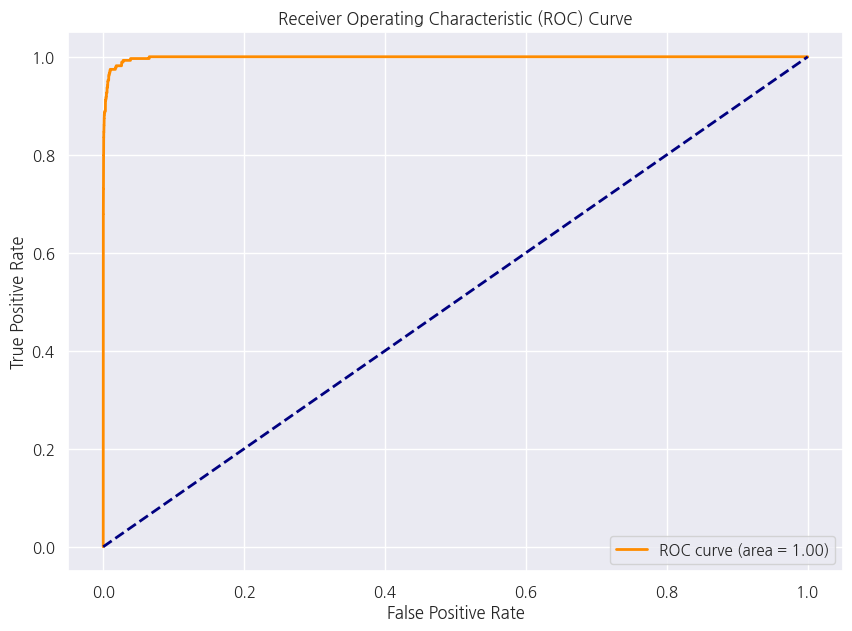

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 여기에 y_test와 y_pred_prob 값을 넣어주세요.
# y_test는 실제 라벨 값을, y_pred_prob는 모델이 예측한 확률 값을 넣어주세요.

# 예측 확률 값 가져오기
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# roc_curve 함수를 사용하여 FPR, TPR, 임계값 계산
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

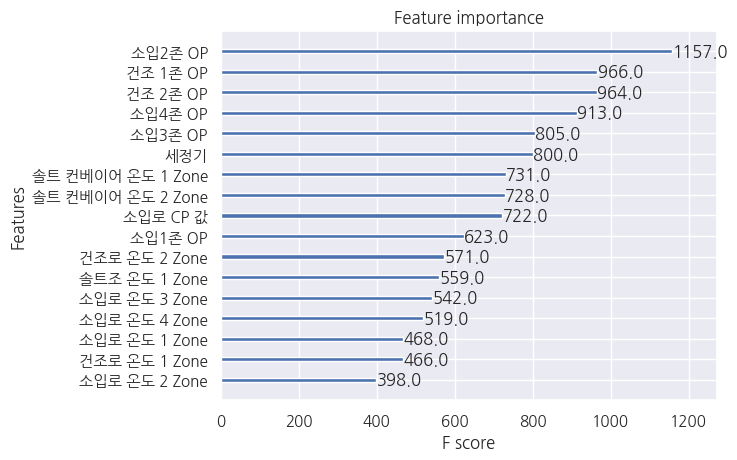

Feature: 건조 1존 OP, Importance: 0.03740550950169563
Feature: 건조 2존 OP, Importance: 0.039643559604883194
Feature: 건조로 온도 1 Zone, Importance: 0.031178781762719154
Feature: 건조로 온도 2 Zone, Importance: 0.047113675624132156
Feature: 세정기, Importance: 0.050229862332344055
Feature: 소입1존 OP, Importance: 0.21889562904834747
Feature: 소입2존 OP, Importance: 0.058560434728860855
Feature: 소입3존 OP, Importance: 0.027212442830204964
Feature: 소입4존 OP, Importance: 0.031055938452482224
Feature: 소입로 CP 값, Importance: 0.026946209371089935
Feature: 소입로 온도 1 Zone, Importance: 0.09189722687005997
Feature: 소입로 온도 2 Zone, Importance: 0.11975549906492233
Feature: 소입로 온도 3 Zone, Importance: 0.052523668855428696
Feature: 소입로 온도 4 Zone, Importance: 0.04616187885403633
Feature: 솔트 컨베이어 온도 1 Zone, Importance: 0.04335181415081024
Feature: 솔트 컨베이어 온도 2 Zone, Importance: 0.04338158294558525
Feature: 솔트조 온도 1 Zone, Importance: 0.034686245024204254


In [55]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# XGBoost 모델의 feature importance를 플로팅합니다.
plot_importance(xgb_classifier)
plt.show()

# 텍스트로도 feature importance를 출력할 수 있습니다.
importances = xgb_classifier.feature_importances_

# feature 이름과 함께 importance를 출력합니다.
for feature, importance in zip(X.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[05:40:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


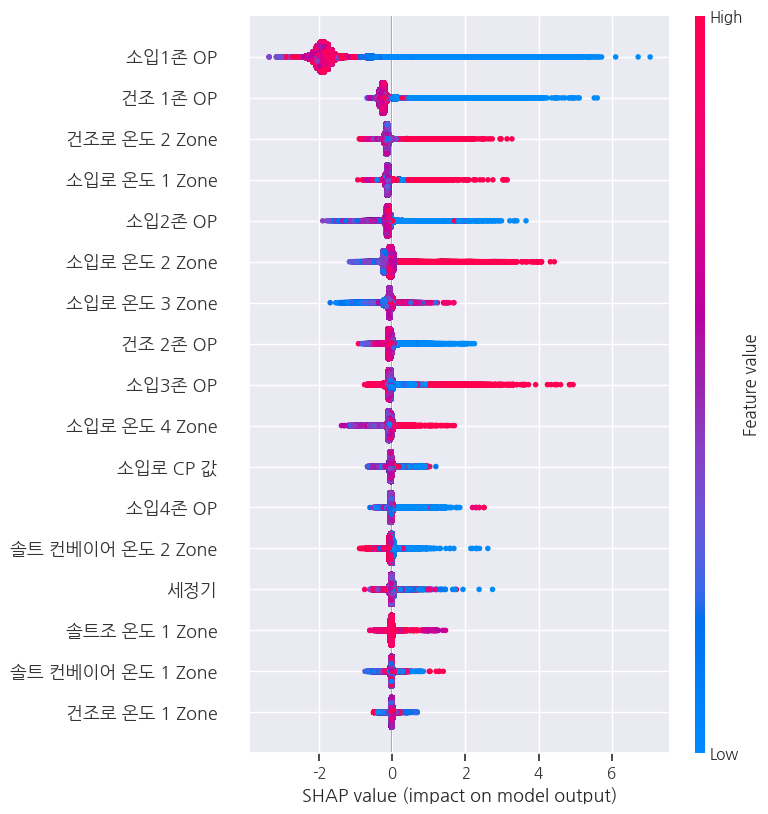

In [56]:
import shap
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [57]:
shap.initjs()
sample_index = 277777  # 확인하고 싶은 데이터 포인트의 인덱스
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index])


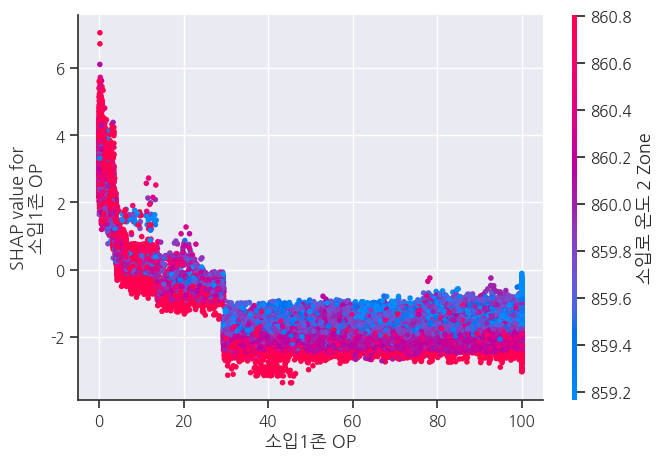

In [58]:
feature_name = '소입1존 OP'
shap.dependence_plot(feature_name, shap_values, X_test)
